In [1]:
import tensorflow as tf
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

In [2]:
InputDim1 = 16384
InputDim2 = 2048
LatentDim = 1024
Epochs    = 10
BatchSize = 200
Workers   = os.cpu_count()
Name      = 'InscopeFilter'

In [3]:
Product_Input  = tf.keras.Input(shape=(InputDim1,))
X1             = tf.keras.layers.Dense(LatentDim, activation='elu')(Product_Input)
X1             = tf.keras.layers.Dropout(0.3)(X1)
X1             = tf.keras.layers.Dense(LatentDim, activation='elu')(X1)
X1             = tf.keras.layers.Dense(LatentDim, activation='elu')(X1)
X1             = tf.keras.layers.Dense(LatentDim, activation='elu')(X1)
X1             = tf.keras.layers.Dense(LatentDim, activation='elu')(X1)
X1             = tf.keras.layers.Dense(LatentDim, activation='elu')(X1)
Reaction_Input = tf.keras.Input(shape=(InputDim2,))
X2             = tf.keras.layers.Dense(LatentDim, activation='elu')(Reaction_Input)
Cosine_Layer   = tf.keras.layers.Dot(axes=1, normalize=True)([X1, X2])
Output         = tf.keras.layers.Dense(1, activation='sigmoid')(Cosine_Layer)
Model = tf.keras.Model(inputs=[Product_Input, Reaction_Input], outputs=[Output], name=Name)

2022-03-21 14:26:46.092396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:26:46.095978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:26:46.096123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:26:46.096451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [4]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

In [5]:
Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [6]:
Model.summary()

Model: "InscopeFilter"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16384)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         16778240    ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dropout[0][0]']                
                                                                                      

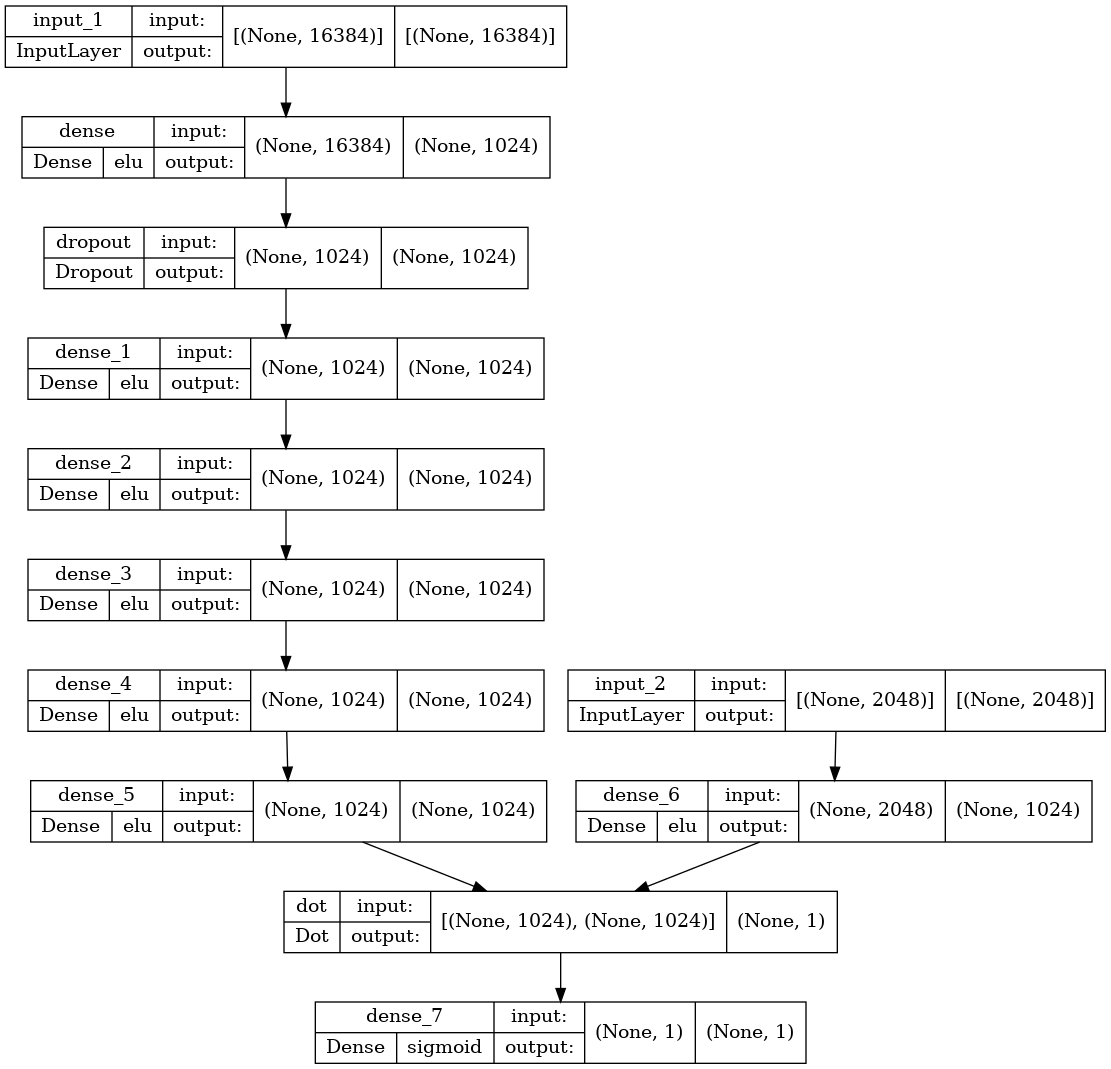

In [7]:
tf.keras.utils.plot_model(Model, show_shapes=True, show_layer_activations=True, to_file='{}.png'.format(Name))

In [8]:
def Fingerprint_to_Array(Mols, Size):
    try:
        FPs  = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), radius=2, useChirality=True, nBits=Size) for m in Mols]
        NFPs = [np.zeros((0,)) for i in range(len(Mols))]
        for i, fp in enumerate(FPs):
            Chem.DataStructs.ConvertToNumpyArray(fp, NFPs[i])
    except ValueError:
        NFPs = [np.zeros((Size,)) for i in range(len(Mols))]
    return sum(NFPs)

In [9]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, Data, Input_Dim1=InputDim1, Input_Dim2=InputDim2, Batch_Size=BatchSize, Shuffle=True):
        self.Data       = Data
        self.Num_Data   = len(Data)
        self.Input_Dim1 = Input_Dim1
        self.Input_Dim2 = Input_Dim2
        self.Batch_Size = Batch_Size
        self.Shuffle    = Shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.Num_Data/self.Batch_Size))

    def __getitem__(self, idx):
        Data_Idx   = self.Data_Idx[self.Batch_Size*idx:self.Batch_Size*(idx+1)]
        Batch_Data = [self.Data[k] for k in Data_Idx]
        X1, X2, Y       = self.__Preprocessing_Data(Batch_Data)
        return [X1, X2], Y

    def __Preprocessing_Data(self, Input_Data):
        X1 = np.zeros((self.Batch_Size, self.Input_Dim1), dtype=np.float64)
        X2 = np.zeros((self.Batch_Size, self.Input_Dim2), dtype=np.float64)
        Y  = np.zeros((self.Batch_Size), dtype=np.int64)
        for i, data in enumerate(Input_Data):
            X1[i] = Fingerprint_to_Array(data['Products'], self.Input_Dim1)
            X2[i] = Fingerprint_to_Array(data['Products'] + data['Reactants'], self.Input_Dim2)
            Y[i] = data['Inscope_Label']
        return X1, X2, Y

    def on_epoch_end(self):
        self.Data_Idx = np.arange(self.Num_Data)
        if self.Shuffle:
            np.random.shuffle(self.Data_Idx)

In [10]:
class Save_Weights(tf.keras.callbacks.Callback):

    def __init__(self):
        super(Save_Weights, self).__init__()
        self.Best_Weights = None

    def on_train_begin(self, logs=None):
        self.Best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.Best):
            self.Best = current
            self.Best_Weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.Best_Weights)

In [11]:
with open('USPTO_InscopeLabeled.json') as File:
    Data = json.load(File)

In [12]:
Pos = 0
Neg = 0
for data in Data:
    if data['Inscope_Label']:
        Pos += 1
    else:
        Neg += 1

In [13]:
PosData = [data for data in Data if data['Inscope_Label']]
NegData = np.random.choice([data for data in Data if not data['Inscope_Label']], size=Pos)
Data    = PosData + list(NegData)

In [14]:
Training_Data, Validating_Data = train_test_split(Data, test_size=0.2, shuffle=True)

In [15]:
len(Training_Data), len(Validating_Data)

(414840, 103710)

In [16]:
History = Model.fit(Generator(Training_Data), 
                    validation_data=Generator(Validating_Data),
                    epochs=Epochs, use_multiprocessing=True, workers=Workers,
                    callbacks=[Save_Weights()])

Epoch 1/10


2022-03-21 14:27:54.072492: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2075/2075 [==============================] - 101s 46ms/step - loss: 0.5240 - tp: 156377.0000 - fp: 53839.0000 - tn: 153853.0000 - fn: 50931.0000 - accuracy: 0.7475 - precision: 0.7439 - recall: 0.7543 - auc: 0.8236 - prc: 0.8112 - val_loss: 0.4712 - val_tp: 42487.0000 - val_fp: 13228.0000 - val_tn: 38605.0000 - val_fn: 9480.0000 - val_accuracy: 0.7812 - val_precision: 0.7626 - val_recall: 0.8176 - val_auc: 0.8614 - val_prc: 0.8495
Epoch 2/10
2075/2075 [==============================] - 101s 46ms/step - loss: 0.4356 - tp: 169727.0000 - fp: 44053.0000 - tn: 163639.0000 - fn: 37581.0000 - accuracy: 0.8033 - precision: 0.7939 - recall: 0.8187 - auc: 0.8822 - prc: 0.8719 - val_loss: 0.4238 - val_tp: 42807.0000 - val_fp: 10597.0000 - val_tn: 41236.0000 - val_fn: 9160.0000 - val_accuracy: 0.8097 - val_precision: 0.8016 - val_recall: 0.8237 - val_auc: 0.8875 - val_prc: 0.8774
Epoch 3/10
2075/2075 [==============================] - 105s 48ms/step - loss: 0.3846 - tp: 176593.0000 - fp: 38388.000

In [17]:
Model.evaluate(Generator(Validating_Data))

519/519 [==============================] - 128s 247ms/step - loss: 0.3740 - tp: 44301.0000 - fp: 8610.0000 - tn: 43223.0000 - fn: 7666.0000 - accuracy: 0.8432 - precision: 0.8373 - recall: 0.8525 - auc: 0.9150 - prc: 0.9057


[0.3739977777004242,
 44301.0,
 8610.0,
 43223.0,
 7666.0,
 0.8431984782218933,
 0.837273895740509,
 0.852483332157135,
 0.915012776851654,
 0.9056607484817505]

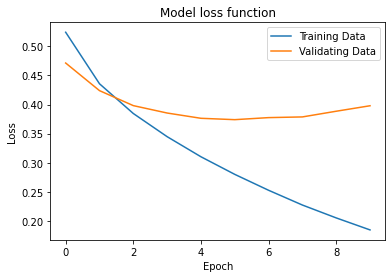

In [18]:
plt.plot(History.epoch, History.history['loss'], History.epoch, History.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Data', 'Validating Data'])
plt.title('Model loss function')
plt.show()

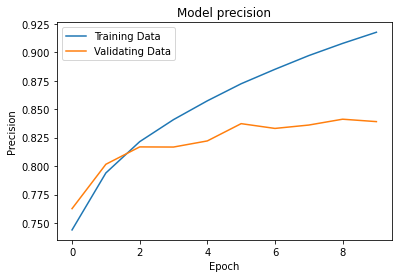

In [19]:
plt.plot(History.epoch, History.history['precision'], History.epoch, History.history['val_precision'])
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Data', 'Validating Data'])
plt.title('Model precision')
plt.show()

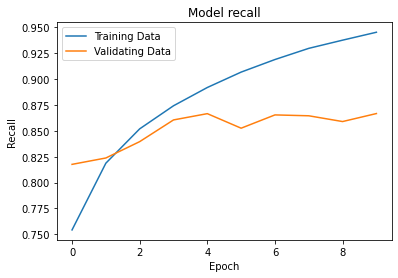

In [20]:
plt.plot(History.epoch, History.history['recall'], History.epoch, History.history['val_recall'])
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Data', 'Validating Data'])
plt.title('Model recall')
plt.show()

In [21]:
Model.save('{}.h5'.format(Name))